### Objective: Count Number of PendingOrders
- Ideas: If another Pmarp 90, Cancel old pending order and create new one. to allow purchase on spike intrabar

In [ ]:
using cAlgo.API;
using cAlgo.API.Internals;

namespace cAlgo.Robots
{
    [Robot(TimeZone = TimeZones.UTC, AccessRights = AccessRights.None)]
    public class PendingOrderCounter : Robot
    {
        private int _barCounter = 0; // Counter to track the number of bars processed

        protected override void OnStart()
        {
            Print("Robot started. Waiting for first 3 bars to create limit orders.");
        }

        protected override void OnBar()
        {
            Print("[START]Pass");
            // Increment the bar counter
            _barCounter++;

            // For the first three bars, create a limit order
            if (_barCounter <= 3)
            {
                // Place a Buy Limit order
                double limitPrice = Bars.LastBar.Close * 0.997;
                Print("Creating limit order on bar {0} at price {1}", _barCounter, limitPrice);
                PlaceLimitOrder(TradeType.Buy, SymbolName, 10000, limitPrice, "LimitOrder", null, null);
                Chart.DrawText($"Buy{Server.Time.Ticks}", "Buy", Bars.LastBar.OpenTime, limitPrice, Color.Green);

            }

            // Count and log the number of pending orders
            int pendingOrderCount = PendingOrders.Count;
            Print("[END]At the end of bar {0}, there are {1} pending orders.", _barCounter, pendingOrderCount);
        }

        protected override void OnStop()
        {
            Print("Robot stopped.");
        }
    }
}


# Orig PMARP Implement PendingOrder, Add Stop Loss
- Working
- but alot of buys are printed

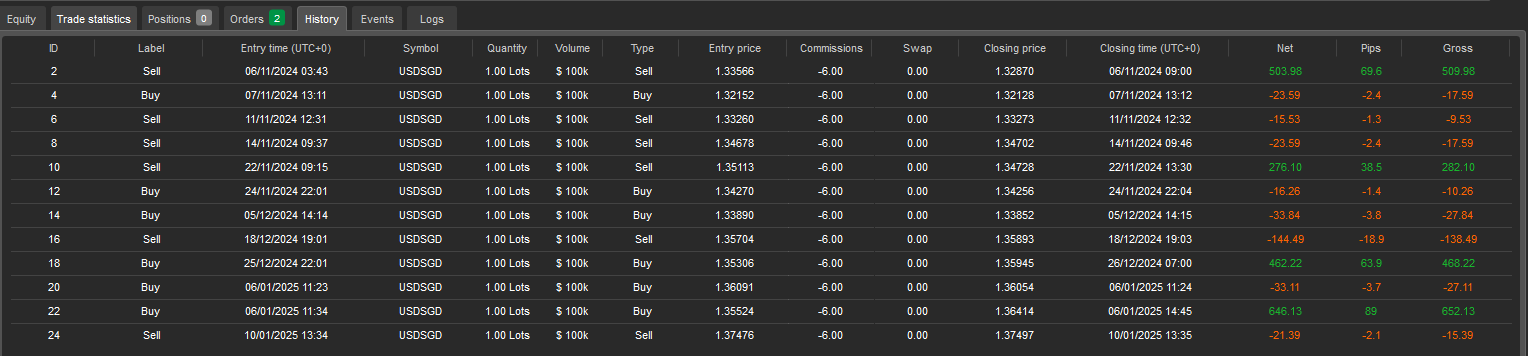

In [ ]:
using cAlgo.API;
using cAlgo.API.Indicators;
using cAlgo.API.Internals;
using System;

namespace cAlgo.Robots
{
    [Robot(TimeZone = TimeZones.UTC, AccessRights = AccessRights.None)]
    public class PMARPStrategy : Robot
    {
        [Parameter("PMAR Length", DefaultValue = 20)]
        public int PMARLength { get; set; }

        [Parameter("PMARP Lookback", DefaultValue = 350)]
        public int PMARPLookback { get; set; }

        [Parameter("High PMARP Alert Level", DefaultValue = 90)]
        public double HighPMARPAlert { get; set; }

        [Parameter("Low PMARP Alert Level", DefaultValue = 10)]
        public double LowPMARPAlert { get; set; }

        [Parameter("Volume", DefaultValue = 100000)]
        public int Volume { get; set; }

        [Parameter("Number of Days", DefaultValue = 7)]
        public int DaysToInclude { get; set; }

        private IndicatorDataSeries _vwmaSeries;
        private double _pmarHigh = 1.0;
        private double _pmarLow = 1.0;
        private int _barCounter = 0; // Counter to track the number of bars processed
        private int counter_buy_limit = 0; 
        private int counter_sell_limit = 0;
        
        protected override void OnStart()
        {
            // Initialize the custom data series for VWMA
            _vwmaSeries = CreateDataSeries();

            // Calculate VWMA for the entire series
            for (int i = PMARLength; i < MarketSeries.Close.Count; i++)
            {
                CalculateVWMA(i);
            }
        }

        protected override void OnBar()
        {
            DateTime utcPlus8Time = Bars.LastBar.OpenTime.AddHours(8);
            _barCounter++;
            // Calculate VWMA for the current bar
            CalculateVWMA(MarketSeries.Close.Count - 1);

            // Calculate PMAR and PMARP
            double price = MarketSeries.Close.LastValue;
            double maValue = _vwmaSeries.LastValue;

            double pmar = price / maValue;
            _pmarHigh = Math.Max(_pmarHigh, pmar);
            _pmarLow = Math.Min(_pmarLow, pmar);

            double pmarp = CalculatePMARP(pmar);

            // Trading logic (last 7 days only)
            DateTime filterDate = Server.Time.AddDays(-DaysToInclude);
            if (MarketSeries.OpenTime.LastValue < filterDate)
                return;

            bool buyCondition = pmarp <= LowPMARPAlert;
            bool sellCondition = pmarp >= HighPMARPAlert;

            Position existingBuyPosition = Positions.Find("Buy");
            Position existingSellPosition = Positions.Find("Sell");
            
            // Print PMARP and Alert Levels for Debugging
            Print("[INFO], Time: {0}, PMARP: {1}", utcPlus8Time, pmarp);
            //Print("Buy Condition: {0}, Sell Condition: {1}", buyCondition, sellCondition);
            // Execute Buy Logic
            if (buyCondition && existingBuyPosition == null)// && counter_buy_limit == 0
            {
                Print("Buy Condition1 triggered: PMARP = {0}, LowPMARPAlert = {1}, counter_buy_limit = {2}", pmarp, LowPMARPAlert, counter_buy_limit);
            
                if (existingSellPosition != null)
                {
                    Print("Existing Short Position... Proceeding to Close");
                    ClosePosition(existingSellPosition);
                    counter_buy_limit = 0 ;
                    Print("Setting buy_limit_counter to 0");
                    Chart.DrawText($"CloseSell{Server.Time.Ticks}", "Close Short", Bars.LastBar.OpenTime, Bars.LastBar.Low, Color.Green);
                }
                
                // If previous buy limit exist, close and open a new one 
                if (counter_buy_limit >= 1)
                {
                    // Iterate through all pending orders and cancel Buy Limit orders
                    foreach (var order in PendingOrders)
                    {
                        if (order.TradeType == TradeType.Buy && order.Label == "Buy")
                        {
                            Print("Cancelling existing Buy Limit order with ID: {0}, Price: {1}", order.Id, order.TargetPrice);
                            CancelPendingOrder(order);
                        }
                    }
                    counter_buy_limit = 0; // Reset the counter after cancelling existing orders
                }
  
                if (counter_buy_limit == 0)
                {
                // Place a Buy Limit order
                double limitPrice = Bars.LastBar.Low * 0.99737;
                Print("Creating buy limit order on bar {0} at price {1}", _barCounter, limitPrice);
                PlaceLimitOrder(TradeType.Buy, SymbolName, Volume, limitPrice, "Buy", limitPrice * 0.99737, null);
                counter_buy_limit++;
                Chart.DrawText($"Buy{Server.Time.Ticks}", "Buy", Bars.LastBar.OpenTime, limitPrice, Color.Green);
                }
            }

            // Execute Sell Logic
            if (sellCondition && existingSellPosition == null ) //&& counter_sell_limit == 0
            {
                Print("Sell Condition1 triggered: PMARP = {0}, HighPMARPAlert = {1}", pmarp, HighPMARPAlert);
            
                if (existingBuyPosition != null)
                {
                    Print("Existing Buy Position... Proceeding to Close");
                    ClosePosition(existingBuyPosition);
                    counter_sell_limit = 0;
                    Print("Setting sell_limit_counter to 0");
                    Chart.DrawText($"CloseBuy{Server.Time.Ticks}", "Close Long", Bars.LastBar.OpenTime, Bars.LastBar.High, Color.Red);
                }
                
                
                // If previous sell limit exists, close and open a new one
                if (counter_sell_limit >= 1)
                {
                    // Iterate through all pending orders and cancel Sell Limit orders
                    foreach (var order in PendingOrders)
                    {
                        if (order.TradeType == TradeType.Sell && order.Label == "Sell")
                        {
                            Print("Cancelling existing Sell Limit order with ID: {0}, Price: {1}", order.Id, order.TargetPrice);
                            CancelPendingOrder(order);
                        }
                    }
                    counter_sell_limit = 0; // Reset the counter after cancelling existing orders
                }
                
                
                
                if (counter_sell_limit == 0)
                {
                double limitPrice = Bars.LastBar.High * 1.00263;
                Print("Creating sell limit order on bar {0} at price {1}", _barCounter, limitPrice);
                PlaceLimitOrder(TradeType.Sell, SymbolName, Volume, limitPrice, "Sell", limitPrice*1.00263 , null);
                counter_sell_limit++;
                Chart.DrawText($"Sell{Server.Time.Ticks}", "Sell", Bars.LastBar.OpenTime, limitPrice, Color.Red);
                }
            }
            int pendingOrderCount = PendingOrders.Count;
            Print("[END]At the end of bar {0}, there are {1} pending orders, existingBuyPosition: {2} existingSellPosition: {3}", _barCounter, pendingOrderCount,existingBuyPosition, existingSellPosition);
        }

        private void CalculateVWMA(int index)
        {
            double sumPriceVolume = 0;
            double sumVolume = 0;

            for (int i = index - PMARLength + 1; i <= index; i++)
            {
                if (i < 0)
                    continue;

                double closePrice = MarketSeries.Close[i];
                double volume = MarketSeries.TickVolume[i];

                sumPriceVolume += closePrice * volume;
                sumVolume += volume;
            }

            if (sumVolume != 0)
                _vwmaSeries[index] = sumPriceVolume / sumVolume;
        }

        private double CalculatePMARP(double pmar)
        {
            double pmarSum = 0;
            int count = Math.Min(PMARPLookback, MarketSeries.Close.Count);

            for (int i = 1; i < count; i++)
            {
                double pastPmar = MarketSeries.Close.Last(i) / _vwmaSeries.Last(i);
                pmarSum += pastPmar > pmar ? 0 : 1;
            }

            return (pmarSum / count) * 100;
        }

        protected override void OnStop()
        {
            // Code to run when the cBot stops
        }
    }
}


# dynamic threshold Values of 0.00263
- Dont know why SL is always 1.3pips

## Many % But Propb wrong

In [ ]:
using cAlgo.API;
using cAlgo.API.Indicators;
using cAlgo.API.Internals;
using System;

namespace cAlgo.Robots
{
    [Robot(TimeZone = TimeZones.UTC, AccessRights = AccessRights.None)]
    public class PMARPStrategy : Robot
    {
        [Parameter("PMAR Length", DefaultValue = 20)]
        public int PMARLength { get; set; }

        [Parameter("PMARP Lookback", DefaultValue = 350)]
        public int PMARPLookback { get; set; }

        [Parameter("High PMARP Alert Level", DefaultValue = 90)]
        public double HighPMARPAlert { get; set; }

        [Parameter("Low PMARP Alert Level", DefaultValue = 10)]
        public double LowPMARPAlert { get; set; }

        [Parameter("Volume", DefaultValue = 100000)]
        public int Volume { get; set; }

        [Parameter("Number of Days", DefaultValue = 7)]
        public int DaysToInclude { get; set; }

        private IndicatorDataSeries _vwmaSeries;
        private double _pmarHigh = 1.0;
        private double _pmarLow = 1.0;
        private int _barCounter = 0; // Counter to track the number of bars processed
        private int counter_buy_limit = 0; 
        private int counter_sell_limit = 0;
        
        protected override void OnStart()
        {
            // Initialize the custom data series for VWMA
            _vwmaSeries = CreateDataSeries();

            // Calculate VWMA for the entire series
            for (int i = PMARLength; i < MarketSeries.Close.Count; i++)
            {
                CalculateVWMA(i);
            }
        }

        protected override void OnBar()
        {
            DateTime utcPlus8Time = Bars.LastBar.OpenTime.AddHours(8);
            _barCounter++;
            // Calculate VWMA for the current bar
            CalculateVWMA(MarketSeries.Close.Count - 1);

            // Calculate PMAR and PMARP
            double price = MarketSeries.Close.LastValue;
            double maValue = _vwmaSeries.LastValue;

            double pmar = price / maValue;
            _pmarHigh = Math.Max(_pmarHigh, pmar);
            _pmarLow = Math.Min(_pmarLow, pmar);

            double pmarp = CalculatePMARP(pmar);

            // Trading logic (last 7 days only)
            DateTime filterDate = Server.Time.AddDays(-DaysToInclude);
            if (MarketSeries.OpenTime.LastValue < filterDate)
                return;

            bool buyCondition = pmarp <= LowPMARPAlert;
            bool sellCondition = pmarp >= HighPMARPAlert;

            Position existingBuyPosition = Positions.Find("Buy");
            Position existingSellPosition = Positions.Find("Sell");
            
            // Print PMARP and Alert Levels for Debugging
            Print("PMARP: {0}", pmarp);//[INFO], Time: {0},  utcPlus8Time
            //Print("Buy Condition: {0}, Sell Condition: {1}", buyCondition, sellCondition);
            // Execute Buy Logic
            if (buyCondition && existingBuyPosition == null)// && counter_buy_limit == 0
            {
                Print("Buy Condition1 triggered: PMARP = {0}, LowPMARPAlert = {1}, counter_buy_limit = {2}", pmarp, LowPMARPAlert, counter_buy_limit);
            
                if (existingSellPosition != null)
                {
                    Print("Existing Short Position... Proceeding to Close");
                    ClosePosition(existingSellPosition);
                    counter_buy_limit = 0 ;
                    Print("Setting buy_limit_counter to 0");
                    Chart.DrawText($"CloseSell{Server.Time.Ticks}", "Close Short", Bars.LastBar.OpenTime, Bars.LastBar.Low, Color.Green);
                }
                
                // If previous buy limit exist, close and open a new one 
                if (counter_buy_limit >= 1)
                {
                    // Iterate through all pending orders and cancel Buy Limit orders
                    foreach (var order in PendingOrders)
                    {
                        if (order.TradeType == TradeType.Buy && order.Label == "Buy")
                        {
                            Print("Cancelling existing Buy Limit order with ID: {0}, Price: {1}", order.Id, order.TargetPrice);
                            CancelPendingOrder(order);
                        }
                    }
                    counter_buy_limit = 0; // Reset the counter after cancelling existing orders
                }
  
                if (counter_buy_limit == 0)
                {
                    // Place a Buy Limit order
                    double limitPrice = Bars.LastBar.Low * (1 - 0.00263); // Calculate buy price (0.263% below the current low)
                    PlaceLimitOrder(TradeType.Buy, SymbolName, Volume, limitPrice, "Buy", 35, 29); // Place the buy limit order
                    Print("Created buy limit order on bar {0} at price {1}, stop loss {2}", _barCounter, limitPrice);
                    counter_buy_limit++;
                    Chart.DrawText($"Buy{Server.Time.Ticks}", "Buy", Bars.LastBar.OpenTime, limitPrice, Color.Green);
                }

            }

            // Execute Sell Logic
            if (sellCondition && existingSellPosition == null ) //&& counter_sell_limit == 0
            {
                Print("Sell Condition1 triggered: PMARP = {0}, HighPMARPAlert = {1}", pmarp, HighPMARPAlert);
            
                if (existingBuyPosition != null)
                {
                    Print("Existing Buy Position... Proceeding to Close");
                    ClosePosition(existingBuyPosition);
                    counter_sell_limit = 0;
                    Print("Setting sell_limit_counter to 0");
                    Chart.DrawText($"CloseBuy{Server.Time.Ticks}", "Close Long", Bars.LastBar.OpenTime, Bars.LastBar.High, Color.Red);
                }
                
                
                // If previous sell limit exists, close and open a new one
                if (counter_sell_limit >= 1)
                {
                    // Iterate through all pending orders and cancel Sell Limit orders
                    foreach (var order in PendingOrders)
                    {
                        if (order.TradeType == TradeType.Sell && order.Label == "Sell")
                        {
                            Print("Cancelling existing Sell Limit order with ID: {0}, Price: {1}", order.Id, order.TargetPrice);
                            CancelPendingOrder(order);
                        }
                    }
                    counter_sell_limit = 0; // Reset the counter after cancelling existing orders
                }
                
                
                
                if (counter_sell_limit == 0)
                {
                    double limitPrice = Bars.LastBar.High * 1.00263; // Sell limit price (0.263% above the current high)

                    Print("Creating sell limit order on bar {0} at price {1})", _barCounter, limitPrice);
                    PlaceLimitOrder(TradeType.Sell, SymbolName, Volume, limitPrice, "Sell", 35, 29); // Place the sell limit order
                    counter_sell_limit++;
                    Chart.DrawText($"Sell{Server.Time.Ticks}", "Sell", Bars.LastBar.OpenTime, limitPrice, Color.Red);
                }

            }
            int pendingOrderCount = PendingOrders.Count;
            Print("[END]At the end of bar {0}, there are {1} pending orders", _barCounter, pendingOrderCount);
        }

        private void CalculateVWMA(int index)
        {
            double sumPriceVolume = 0;
            double sumVolume = 0;

            for (int i = index - PMARLength + 1; i <= index; i++)
            {
                if (i < 0)
                    continue;

                double closePrice = MarketSeries.Close[i];
                double volume = MarketSeries.TickVolume[i];

                sumPriceVolume += closePrice * volume;
                sumVolume += volume;
            }

            if (sumVolume != 0)
                _vwmaSeries[index] = sumPriceVolume / sumVolume;
        }

        private double CalculatePMARP(double pmar)
        {
            double pmarSum = 0;
            int count = Math.Min(PMARPLookback, MarketSeries.Close.Count);

            for (int i = 1; i < count; i++)
            {
                double pastPmar = MarketSeries.Close.Last(i) / _vwmaSeries.Last(i);
                pmarSum += pastPmar > pmar ? 0 : 1;
            }

            return (pmarSum / count) * 100;
        }

        protected override void OnStop()
        {
            // Code to run when the cBot stops
        }
    }
}


## Correct but need to:
### final version for v4
1. Remove all the vars not needed for SL and TP vqalues.
2. Check top why keep opening positions
3. Maybe Improven if last 4 bars delta change = idk 0.00263? so use this technique etc.? else not? to allow for execution only on high volatility??


# FINAL VERSION
### TradingView v4:

In [ ]:

days_to_include =90

// If Ticker == XAUUSD
var float position_size = na
if syminfo.ticker == "XAUUSD"
    position_size := 20000
else
    position_size := 100000

time_filter = time >= (timenow - days_to_include * 24 * 60 * 60 * 1000)  // Last 7 days in milliseconds//

// Declare orig_entry as a persistent variable
var float orig_entry = na
// Declare orig_entry as a persistent variable


if time_filter
    // Define thresholds
    pmarp_buy_extreme = 10  // Buy when PMARP is below 10% (oversold)
    pmarp_sell_extreme = 90  // Sell when PMARP is above 90% (overbought)

    // Profit margin percentage (0.263%)
    margin = 0.00263 //DELTA

    // Stop loss percentage (0.263% * 2 = 0.526%)
    stop_loss_margin = margin * 1 //DELTA: 1 or 2

    // Buy/Sell Conditions
    buy_condition = (pmarp <= pmarp_buy_extreme)
    sell_condition = (pmarp >= pmarp_sell_extreme)

    // Entry and Exit Logic with Margin and Stop Loss
    if buy_condition and strategy.position_size == 0
        // Adjusted buy price and stop loss
        buy_price = low * (1 - margin)
        stop_loss_price = buy_price * (1 - stop_loss_margin)
        
        // Place buy order with stop loss
        strategy.entry("Buy", strategy.long, qty=position_size, limit=buy_price)
        strategy.exit("Stop Loss (Long)", from_entry="Buy", stop=stop_loss_price)
        // label.new(bar_index, 0, "Buy (Limit)", style=label.style_label_up, color=color.new(color.green, 0), textcolor=color.white)
        label.new(bar_index, 0, "BuyLow: " + str.tostring(low) + ", Limit: " + str.tostring(buy_price), style=label.style_label_up, color=color.new(color.green, 0), textcolor=color.white)

    if sell_condition and strategy.position_size == 0
        // Adjusted sell price and stop loss
        sell_price = high * (1 + margin)
        stop_loss_price = sell_price * (1 + stop_loss_margin)
        
        // Place sell order with stop loss
        strategy.entry("Sell", strategy.short, qty=position_size, limit=sell_price)
        strategy.exit("Stop Loss (Short)", from_entry="Sell", stop=stop_loss_price)
        label.new(bar_index, 0, "Sell (Limit)", style=label.style_label_down, color=color.new(color.red, 0), textcolor=color.white)

    // Quickest Possible Exit Without Stop Loss Adjustment
    if strategy.position_size > 0 and sell_condition
        strategy.close("Buy")
        label.new(bar_index, 0, "Close Long", style=label.style_label_down, color=color.new(color.red, 0), textcolor=color.white)

    if strategy.position_size < 0 and buy_condition
        strategy.close("Sell")
        label.new(bar_index, 0, "Close Short", style=label.style_label_up, color=color.new(color.green, 0), textcolor=color.white)


### cTrader v4 DNT

In [ ]:
using cAlgo.API;
using cAlgo.API.Indicators;
using cAlgo.API.Internals;
using System;

namespace cAlgo.Robots
{
    [Robot(TimeZone = TimeZones.UTC, AccessRights = AccessRights.None)]
    public class PMARPStrategy : Robot
    {
        [Parameter("PMAR Length", DefaultValue = 20)]
        public int PMARLength { get; set; }

        [Parameter("PMARP Lookback", DefaultValue = 350)]
        public int PMARPLookback { get; set; }

        [Parameter("High PMARP Alert Level", DefaultValue = 90)]
        public double HighPMARPAlert { get; set; }

        [Parameter("Low PMARP Alert Level", DefaultValue = 10)]
        public double LowPMARPAlert { get; set; }

        [Parameter("Volume", DefaultValue = 100000)]
        public int Volume { get; set; }

        [Parameter("Number of Days", DefaultValue = 7)]
        public int DaysToInclude { get; set; }

        private IndicatorDataSeries _vwmaSeries;
        private double _pmarHigh = 1.0;
        private double _pmarLow = 1.0;
        private int _barCounter = 0; // Counter to track the number of bars processed
        private int counter_buy_limit = 0; 
        private int counter_sell_limit = 0;
        
        protected override void OnStart()
        {
            // Initialize the custom data series for VWMA
            _vwmaSeries = CreateDataSeries();

            // Calculate VWMA for the entire series
            for (int i = PMARLength; i < MarketSeries.Close.Count; i++)
            {
                CalculateVWMA(i);
            }
        }

        protected override void OnBar()
        {
            DateTime utcPlus8Time = Bars.LastBar.OpenTime.AddHours(8);
            _barCounter++;
            // Calculate VWMA for the current bar
            CalculateVWMA(MarketSeries.Close.Count - 1);

            // Calculate PMAR and PMARP
            double price = MarketSeries.Close.LastValue;
            double maValue = _vwmaSeries.LastValue;

            double pmar = price / maValue;
            _pmarHigh = Math.Max(_pmarHigh, pmar);
            _pmarLow = Math.Min(_pmarLow, pmar);

            double pmarp = CalculatePMARP(pmar);

            // Trading logic (last 7 days only)
            DateTime filterDate = Server.Time.AddDays(-DaysToInclude);
            if (MarketSeries.OpenTime.LastValue < filterDate)
                return;

            bool buyCondition = pmarp <= LowPMARPAlert;
            bool sellCondition = pmarp >= HighPMARPAlert;

            Position existingBuyPosition = Positions.Find("Buy");
            Position existingSellPosition = Positions.Find("Sell");
            
            // Print PMARP and Alert Levels for Debugging
            Print("PMARP: {0}", pmarp);//[INFO], Time: {0},  utcPlus8Time
            //Print("Buy Condition: {0}, Sell Condition: {1}", buyCondition, sellCondition);
            // Execute Buy Logic
            if (buyCondition && existingBuyPosition == null)// && counter_buy_limit == 0
            {
                Print("Buy Condition1 triggered: PMARP = {0}, LowPMARPAlert = {1}, counter_buy_limit = {2}", pmarp, LowPMARPAlert, counter_buy_limit);
            
                if (existingSellPosition != null)
                {
                    Print("Existing Short Position... Proceeding to Close");
                    ClosePosition(existingSellPosition);
                    counter_buy_limit = 0 ;
                    Print("Setting buy_limit_counter to 0");
                    Chart.DrawText($"CloseSell{Server.Time.Ticks}", "Close Short", Bars.LastBar.OpenTime, Bars.LastBar.Low, Color.Green);
                }
                
                // If previous buy limit exist, close and open a new one 
                if (counter_buy_limit >= 1)
                {
                    // Iterate through all pending orders and cancel Buy Limit orders
                    foreach (var order in PendingOrders)
                    {
                        if (order.TradeType == TradeType.Buy && order.Label == "Buy")
                        {
                            Print("Cancelling existing Buy Limit order with ID: {0}, Price: {1}", order.Id, order.TargetPrice);
                            CancelPendingOrder(order);
                        }
                    }
                    counter_buy_limit = 0; // Reset the counter after cancelling existing orders
                }
  
                if (counter_buy_limit == 0)
                {
                    // Place a Buy Limit order
                    double limitPrice = Bars.LastBar.Low * (1 - 0.00263); // Calculate buy price (0.263% below the current low)
                    //double pipSize = Symbol.PipSize; // Get the pip size of the symbol
                    //int stopLossPips = 50; // Set the stop-loss in pips
                    //double stopLossPrice = limitPrice - (pipSize * stopLossPips); // Calculate stop-loss price based on pip size

                    Print("Creating buy limit order on bar {0} at price {1}", _barCounter, limitPrice);
                    PlaceLimitOrder(TradeType.Buy, SymbolName, Volume, limitPrice, "Buy", 29, 35); // Place the buy limit order
                    counter_buy_limit++;
                    Chart.DrawText($"Buy{Server.Time.Ticks}", "Buy", Bars.LastBar.OpenTime, limitPrice, Color.Green);
                }

            }

            // Execute Sell Logic
            if (sellCondition && existingSellPosition == null ) //&& counter_sell_limit == 0
            {
                Print("Sell Condition1 triggered: PMARP = {0}, HighPMARPAlert = {1}", pmarp, HighPMARPAlert);
            
                if (existingBuyPosition != null)
                {
                    Print("Existing Buy Position... Proceeding to Close");
                    ClosePosition(existingBuyPosition);
                    counter_sell_limit = 0;
                    Print("Setting sell_limit_counter to 0");
                    Chart.DrawText($"CloseBuy{Server.Time.Ticks}", "Close Long", Bars.LastBar.OpenTime, Bars.LastBar.High, Color.Red);
                }
                
                
                // If previous sell limit exists, close and open a new one
                if (counter_sell_limit >= 1)
                {
                    // Iterate through all pending orders and cancel Sell Limit orders
                    foreach (var order in PendingOrders)
                    {
                        if (order.TradeType == TradeType.Sell && order.Label == "Sell")
                        {
                            Print("Cancelling existing Sell Limit order with ID: {0}, Price: {1}", order.Id, order.TargetPrice);
                            CancelPendingOrder(order);
                        }
                    }
                    counter_sell_limit = 0; // Reset the counter after cancelling existing orders
                }
                
                
                
                if (counter_sell_limit == 0)
                {
                    double limitPrice = Bars.LastBar.High * 1.00263; // Sell limit price (0.263% above the current high)
                    //double pipSize = Symbol.PipSize; // Get the pip size of the symbol
                    //int stopLossPips = 50; // Set the stop-loss in pips
                    //double stopLossPrice = limitPrice + (pipSize * stopLossPips); // Calculate stop-loss price based on pip size

                    Print("Creating sell limit order on bar {0} at price {1}", _barCounter, limitPrice);
                    PlaceLimitOrder(TradeType.Sell, SymbolName, Volume, limitPrice, "Sell", 29, 35); // Place the sell limit order
                    counter_sell_limit++;
                    Chart.DrawText($"Sell{Server.Time.Ticks}", "Sell", Bars.LastBar.OpenTime, limitPrice, Color.Red);
                }

            }
            int pendingOrderCount = PendingOrders.Count;
            Print("[END]At the end of bar {0}, there are {1} pending orders", _barCounter, pendingOrderCount);
        }

        private void CalculateVWMA(int index)
        {
            double sumPriceVolume = 0;
            double sumVolume = 0;

            for (int i = index - PMARLength + 1; i <= index; i++)
            {
                if (i < 0)
                    continue;

                double closePrice = MarketSeries.Close[i];
                double volume = MarketSeries.TickVolume[i];

                sumPriceVolume += closePrice * volume;
                sumVolume += volume;
            }

            if (sumVolume != 0)
                _vwmaSeries[index] = sumPriceVolume / sumVolume;
        }

        private double CalculatePMARP(double pmar)
        {
            double pmarSum = 0;
            int count = Math.Min(PMARPLookback, MarketSeries.Close.Count);

            for (int i = 1; i < count; i++)
            {
                double pastPmar = MarketSeries.Close.Last(i) / _vwmaSeries.Last(i);
                pmarSum += pastPmar > pmar ? 0 : 1;
            }

            return (pmarSum / count) * 100;
        }

        protected override void OnStop()
        {
            // Code to run when the cBot stops
        }
    }
}


# V4 Testing different Variables
#### Findings:

#### for USDSGD : 17/10/2024 -> 17/01/2025 
0. ORIGINAL PMARP : $9244.49 (92%), 133 Trades
1. Original Extreme $1182.61 (12%), eg. use Bars.LastBar.Low * (1 - 0.00263)
2. Without extremes, just use: Bars.LastBar.Low : $9319.56 (93%)
 - 0 pipsize: $9319.56 (93%), 127 trades
3. Without extremes, just use: Bars.LastBar.Low +- pipSize
 - 9.8 pipsize: $2181.05 (22%)
 - 10 pipsize: $2687.64 (27%)
 - 12 pipsize: $3116.07 (31%)
 - 15 pipsize: $4249.47 (42%), 59 trades*
 - 16 pipsize: $4117.60 (42%), 53 trades
 - 20 pipsize: $2586.55 (26%), 33 trades 
 - 29 pipsize: $2449.07 (24%), 14 trades
 

In [ ]:
using cAlgo.API;
using cAlgo.API.Indicators;
using cAlgo.API.Internals;
using System;

namespace cAlgo.Robots
{
    [Robot(TimeZone = TimeZones.UTC, AccessRights = AccessRights.None)]
    public class PMARPStrategy : Robot
    {
        [Parameter("PMAR Length", DefaultValue = 20)]
        public int PMARLength { get; set; }

        [Parameter("PMARP Lookback", DefaultValue = 350)]
        public int PMARPLookback { get; set; }

        [Parameter("High PMARP Alert Level", DefaultValue = 90)]
        public double HighPMARPAlert { get; set; }

        [Parameter("Low PMARP Alert Level", DefaultValue = 10)]
        public double LowPMARPAlert { get; set; }

        [Parameter("Volume", DefaultValue = 100000)]
        public int Volume { get; set; }

        [Parameter("Number of Days", DefaultValue = 7)]
        public int DaysToInclude { get; set; }

        [Parameter("Pips Added From Low & High", DefaultValue = 15)]
        public double pip_thresh_added { get; set; }
        
        [Parameter("SL_pips", DefaultValue = 29)]
        public int SL_pips { get; set; }
        
        [Parameter("TP_pips", DefaultValue = 35)]
        public int TP_pips { get; set; }
        
        private IndicatorDataSeries _vwmaSeries;
        private double _pmarHigh = 1.0;
        private double _pmarLow = 1.0;
        private int _barCounter = 0; // Counter to track the number of bars processed
        private int counter_buy_limit = 0; 
        private int counter_sell_limit = 0;
        
        protected override void OnStart()
        {
            // Initialize the custom data series for VWMA
            _vwmaSeries = CreateDataSeries();

            // Calculate VWMA for the entire series
            for (int i = PMARLength; i < MarketSeries.Close.Count; i++)
            {
                CalculateVWMA(i);
            }
        }

        protected override void OnBar()
        {
            DateTime utcPlus8Time = Bars.LastBar.OpenTime.AddHours(8);
            _barCounter++;
            // Calculate VWMA for the current bar
            CalculateVWMA(MarketSeries.Close.Count - 1);

            // Calculate PMAR and PMARP
            double price = MarketSeries.Close.LastValue;
            double maValue = _vwmaSeries.LastValue;

            double pmar = price / maValue;
            _pmarHigh = Math.Max(_pmarHigh, pmar);
            _pmarLow = Math.Min(_pmarLow, pmar);

            double pmarp = CalculatePMARP(pmar);

            // Trading logic (last 7 days only)
            DateTime filterDate = Server.Time.AddDays(-DaysToInclude);
            if (MarketSeries.OpenTime.LastValue < filterDate)
                return;

            bool buyCondition = pmarp <= LowPMARPAlert;
            bool sellCondition = pmarp >= HighPMARPAlert;

            Position existingBuyPosition = Positions.Find("Buy");
            Position existingSellPosition = Positions.Find("Sell");
            
            // Print PMARP and Alert Levels for Debugging
            Print("PMARP: {0}", pmarp);//[INFO], Time: {0},  utcPlus8Time
            //Print("Buy Condition: {0}, Sell Condition: {1}", buyCondition, sellCondition);
            // Execute Buy Logic
            if (buyCondition && existingBuyPosition == null)// && counter_buy_limit == 0
            {
                Print("Buy Condition1 triggered: PMARP = {0}, LowPMARPAlert = {1}, counter_buy_limit = {2}", pmarp, LowPMARPAlert, counter_buy_limit);
            
                if (existingSellPosition != null)
                {
                    Print("Existing Short Position... Proceeding to Close");
                    ClosePosition(existingSellPosition);
                    counter_buy_limit = 0 ;
                    Print("Setting buy_limit_counter to 0");
                    Chart.DrawText($"CloseSell{Server.Time.Ticks}", "Close Short", Bars.LastBar.OpenTime, Bars.LastBar.Low, Color.Green);
                }
                
                // If previous buy limit exist, close and open a new one 
                if (counter_buy_limit >= 1)
                {
                    // Iterate through all pending orders and cancel Buy Limit orders
                    foreach (var order in PendingOrders)
                    {
                        if (order.TradeType == TradeType.Buy && order.Label == "Buy")
                        {
                            Print("Cancelling existing Buy Limit order with ID: {0}, Price: {1}", order.Id, order.TargetPrice);
                            CancelPendingOrder(order);
                        }
                    }
                    counter_buy_limit = 0; // Reset the counter after cancelling existing orders
                }
  
                if (counter_buy_limit == 0)
                {
                    // Place a Buy Limit order
                    double limitPrice = Bars.LastBar.Low - pip_thresh_added * Symbol.PipSize; //  * (1 - 0.00263) Calculate buy price (0.263% below the current low)
                    //double pipSize = Symbol.PipSize; // Get the pip size of the symbol
                    //int stopLossPips = 50; // Set the stop-loss in pips
                    //double stopLossPrice = limitPrice - (pipSize * stopLossPips); // Calculate stop-loss price based on pip size

                    Print("Creating buy limit order on bar {0} at price {1}", _barCounter, limitPrice);
                    PlaceLimitOrder(TradeType.Buy, SymbolName, Volume, limitPrice, "Buy", 29, 35); // Place the buy limit order
                    counter_buy_limit++;
                    Chart.DrawText($"Buy{Server.Time.Ticks}", "Buy", Bars.LastBar.OpenTime, limitPrice, Color.Green);
                }

            }

            // Execute Sell Logic
            if (sellCondition && existingSellPosition == null ) //&& counter_sell_limit == 0
            {
                Print("Sell Condition1 triggered: PMARP = {0}, HighPMARPAlert = {1}", pmarp, HighPMARPAlert);
            
                if (existingBuyPosition != null)
                {
                    Print("Existing Buy Position... Proceeding to Close");
                    ClosePosition(existingBuyPosition);
                    counter_sell_limit = 0;
                    Print("Setting sell_limit_counter to 0");
                    Chart.DrawText($"CloseBuy{Server.Time.Ticks}", "Close Long", Bars.LastBar.OpenTime, Bars.LastBar.High, Color.Red);
                }
                
                
                // If previous sell limit exists, close and open a new one
                if (counter_sell_limit >= 1)
                {
                    // Iterate through all pending orders and cancel Sell Limit orders
                    foreach (var order in PendingOrders)
                    {
                        if (order.TradeType == TradeType.Sell && order.Label == "Sell")
                        {
                            Print("Cancelling existing Sell Limit order with ID: {0}, Price: {1}", order.Id, order.TargetPrice);
                            CancelPendingOrder(order);
                        }
                    }
                    counter_sell_limit = 0; // Reset the counter after cancelling existing orders
                }
                
                
                
                if (counter_sell_limit == 0)
                {
                    double limitPrice = Bars.LastBar.High + pip_thresh_added * Symbol.PipSize; //* 1.00263 Sell limit price (0.263% above the current high)
                    //double pipSize = Symbol.PipSize; // Get the pip size of the symbol
                    //int stopLossPips = 50; // Set the stop-loss in pips
                    //double stopLossPrice = limitPrice + (pipSize * stopLossPips); // Calculate stop-loss price based on pip size

                    Print("Creating sell limit order on bar {0} at price {1}", _barCounter, limitPrice);
                    PlaceLimitOrder(TradeType.Sell, SymbolName, Volume, limitPrice, "Sell", 29, 35); // Place the sell limit order
                    counter_sell_limit++;
                    Chart.DrawText($"Sell{Server.Time.Ticks}", "Sell", Bars.LastBar.OpenTime, limitPrice, Color.Red);
                }

            }
            int pendingOrderCount = PendingOrders.Count;
            Print("[END]At the end of bar {0}, there are {1} pending orders", _barCounter, pendingOrderCount);
        }

        private void CalculateVWMA(int index)
        {
            double sumPriceVolume = 0;
            double sumVolume = 0;

            for (int i = index - PMARLength + 1; i <= index; i++)
            {
                if (i < 0)
                    continue;

                double closePrice = MarketSeries.Close[i];
                double volume = MarketSeries.TickVolume[i];

                sumPriceVolume += closePrice * volume;
                sumVolume += volume;
            }

            if (sumVolume != 0)
                _vwmaSeries[index] = sumPriceVolume / sumVolume;
        }

        private double CalculatePMARP(double pmar)
        {
            double pmarSum = 0;
            int count = Math.Min(PMARPLookback, MarketSeries.Close.Count);

            for (int i = 1; i < count; i++)
            {
                double pastPmar = MarketSeries.Close.Last(i) / _vwmaSeries.Last(i);
                pmarSum += pastPmar > pmar ? 0 : 1;
            }

            return (pmarSum / count) * 100;
        }

        protected override void OnStop()
        {
            // Code to run when the cBot stops
        }
    }
}
